In [1]:
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import pandas as pd
import scipy.optimize as sc
import scipy

In [2]:
# Read CCD Calibration parameters
calibration_CCD = pd.read_csv('CCD_params.csv')

c_a = calibration_CCD['params_linear'][0]
c_b = calibration_CCD['params_linear'][1]
u_c_a = calibration_CCD['cov_linear'][0]
u_c_b = calibration_CCD['cov_linear'][1]


def wave(lamb, u_lamb):
    w = lamb * c_a + c_b
    u_w = np.sqrt((lamb * u_c_a)**2 + (u_c_b)**2 + (c_a * u_lamb)**2)
    return w, u_w
print(calibration_CCD['laser'])

w_laser = calibration_CCD['laser_corr']


def d_v(lamb, u_lamb):
    v = 1/w_laser[0] - 1/lamb
    u_v = np.sqrt((w_laser[1]/w_laser[0]**2)**2 + (u_lamb/lamb**2)**2)
    return v, u_v

0    531.817984
1    531.817984
Name: laser, dtype: float64


In [3]:
def lorentz(x, A, w0, gamma, C):
    '''Function of a Lorentz-curve.

    w0 : position of maximum
    gamma : curve width
    '''
    return A/((x**2 - w0**2)**2 + gamma**2 * w0**2) + C


def voigt(x, mean, sigma, gamma, A, c):
    return A * scipy.special.voigt_profile(x-mean, sigma, gamma) + c

def gauss(x, A, mu, sigma, C):
    return A * np.exp(-(x-mu)**2 / (2*sigma**2)) + C


def doppel_gauss(x, A1, mu1, sigma1, A2, mu2, sigma2, C):
    return (A1 * np.exp(-(x-mu1)**2 / (2*sigma1**2)) + A2 * np.exp(-(x-mu2)**2 / (2*sigma2**2))) + C


def linear(x,a,b):
    return a*x+b

In [4]:
def save_params(concentration, coefficients, covariance):
    wavelength = []
    u_wavelength = []
    dvs = []
    u_dvs = []
    for i in range(len(coefficients)):
        if coefficients[i,1] > 0:
            w = wave(coefficients[i,1], np.sqrt(covariance[i,1,1]))
            wavelength.append(w[0])
            u_wavelength.append(w[1])
        
            nu = np.array(d_v(*w)) * 1e7
            dvs.append(nu[0])
            u_dvs.append(nu[1])
        
            print('lambda = {0:3.5g} \pm {1:1.2g}'.format(w[0], w[1]))
            print('d_nu = {0:3.3g} \pm {1:1.2g}'.format(nu[0], nu[1]))
        if coefficients[i,4] > 0:
            w = wave(coefficients[i,4], np.sqrt(covariance[i,4,4]))
            wavelength.append(w[0])
            u_wavelength.append(w[1])
        
            nu = np.array(d_v(*w)) * 1e7
            dvs.append(nu[0])
            u_dvs.append(nu[1])
            print('lambda = {0:3.5g} \pm {1:1.2g}'.format(w[0], w[1]))
            print('d_nu = {0:3.3g} \pm {1:1.2g}'.format(nu[0], nu[1]))

    output_data = pd.DataFrame({'$\lambda_{CCD}$': wavelength,
                                '$u(\lambda_{CCD})$': u_wavelength,
                                '$d_\nu$': dvs,
                                '$u(d_\nu)$': u_dvs})

    output_data.to_csv('Calibration_Files_CCD/Ethanol_'+ str(concentration) + 'ml.csv', index=False)
    print('Successfully saved!')

In [5]:
colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

def draw_spectrum(num_fit, x, y, a, xaxis,xaxis1, coefficients,
                  covariance, title, concentration, func1=gauss,func2=gauss,
                  log=False, ylims=[0,200],
                  xlims=[5050,5600], avline=True):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(x, y, marker = 'x', lw = 0, ms = 5, color = 'grey')
    
    i=0
    j=1
    if func1==doppel_gauss:
        params = coefficients[i]
        cov = covariance[i]
        if avline:
            ax.axvline(x[a[i][0]], color=colors[i], ls='--', lw=1)
            ax.axvline(x[a[i][1]], color=colors[i], ls='--', lw=1)
        ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
        label = r'$\mu_1 = ({:.1f} \pm {:.1f})\,$nm, $\mu_2 = ({:.1f} \pm {:.1f})\,$nm'.format(
            params[1], np.sqrt(cov[1,1]), params[4], np.sqrt(cov[4,4])))

    elif func1==gauss:
        params = coefficients[i,:4]
        cov = covariance[i,:4,:4]
        if avline:
            ax.axvline(x[a[i][0]], color=colors[i], ls='--', lw=1)
            ax.axvline(x[a[i][1]], color=colors[i], ls='--', lw=1)
        ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i],
        label = r'$\mu_1 = ({:.2f} \pm {:.2f})\,$nm'.format(
            params[1], np.sqrt(cov[1,1])))

    for i in range(1,num_fit-1):
        params = coefficients[i,:4]
        cov = covariance[i,:4,:4]
        if avline:
            ax.axvline(x[a[i][0]], color=colors[i], ls='--', lw=1)
            ax.axvline(x[a[i][1]], color=colors[i], ls='--', lw=1)
        j+=1
        ax.plot(xaxis[i],gauss(xaxis[i], *params), color=colors[i],
            label = r'$\mu_{} = ({:.2f} \pm {:.2f})\,$nm'.format(j, params[1], np.sqrt(cov[1,1])))
            
    i=i+1
    if func2==doppel_gauss:
        params = coefficients[i]
        cov = covariance[i]
        if avline:
            ax.axvline(x[a[i][0]], color=colors[i], ls='--', lw=1)
            ax.axvline(x[a[i][1]], color=colors[i], ls='--', lw=1)
        ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i],
        label = r'$\mu_{} = ({:.1f} \pm {:.1f})\,$nm, $\mu_{} = ({:.1f} \pm {:.1f})\,$nm'.format(j+1,
            params[1], np.sqrt(cov[1,1]),j+2, params[4], np.sqrt(cov[4,4])))
    else:
        params = coefficients[i,:4]
        cov = covariance[i,:4,:4]
        if avline:
            ax.axvline(x[a[i][0]], color=colors[i], ls='--', lw=1)
            ax.axvline(x[a[i][1]], color=colors[i], ls='--', lw=1)
        ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i],
        label = r'$\mu_{} = ({:.2f} \pm {:.2f})\,$nm'.format(j+1,
            params[1], np.sqrt(cov[1,1])))
    
    ax.set_xlabel(r'Channel $x_\mathrm{CCD}\,$[nm]')
    ax.set_ylabel(r'Intensity [a.u.]')
    ax.set_title(title, size=15)
    ax.axvline(calibration_CCD['laser'][0], ls='--', color = 'green', label=r'laser wavelength', lw=1)
    ax.legend()
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    if log:
        ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig('Figures/Ethanol_'+str(concentration)+'_ml.pdf', dpi=800)
    plt.show()

In [6]:
def fit_func(N, x, y, a, p0s,p1s, func1, func2, show):
    coefficients = np.zeros((N, 7))
    covariance = np.zeros((N, 7, 7))
    i = 0
    if func1==gauss:
        params, cov = sc.curve_fit(func1, x[a[i][0]:a[i][1]], y[a[i][0]:a[i][1]],
                                p0 = p0s[i])
        coefficients[i,:4] = params
        covariance[i,:4,:4] = cov
        if show:
            print(params, np.sqrt(np.diagonal(cov)))
    elif func1==doppel_gauss:
        params, cov = sc.curve_fit(func1, x[a[i][0]:a[i][1]], y[a[i][0]:a[i][1]],
                                p0 = p1s[0])
        coefficients[i] = params
        covariance[i] = cov
        if show:
            print(params, np.sqrt(np.diagonal(cov)))

    for i in range(1,N-1):
        params, cov = sc.curve_fit(gauss, x[a[i][0]:a[i][1]], y[a[i][0]:a[i][1]], p0 = p0s[i])
        if show:
            print(params, np.sqrt(np.diagonal(cov)))
        coefficients[i,:4] = params
        covariance[i,:4,:4] = cov
    i = i+1
    if func2==gauss:
        params, cov = sc.curve_fit(func2, x[a[i][0]:a[i][1]], y[a[i][0]:a[i][1]],
                                p0 = p0s[i])
        coefficients[i,:4] = params
        covariance[i,:4,:4] = cov
        if show:
            print(params, np.sqrt(np.diagonal(cov)))
    elif func2==doppel_gauss:
        params, cov = sc.curve_fit(func2, x[a[i][0]:a[i][1]], y[a[i][0]:a[i][1]],
                                p0 = p1s[1])
        coefficients[i] = params
        covariance[i] = cov
        if show:
            print(params, np.sqrt(np.diagonal(cov)))
    return coefficients, covariance

**Ethanol concentration determination**

<ipython-input-7-4d9532f59611>:42: RuntimeWarning: invalid value encountered in sqrt
  u_params[i,:] = np.sqrt(covariance)


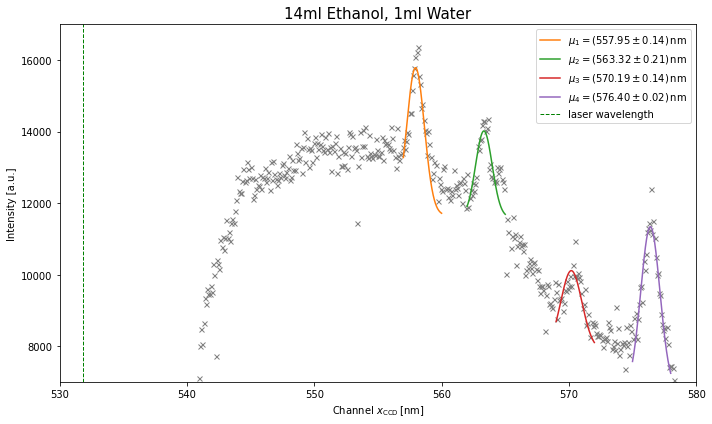

<ipython-input-7-4d9532f59611>:42: RuntimeWarning: invalid value encountered in sqrt
  u_params[i,:] = np.sqrt(covariance)


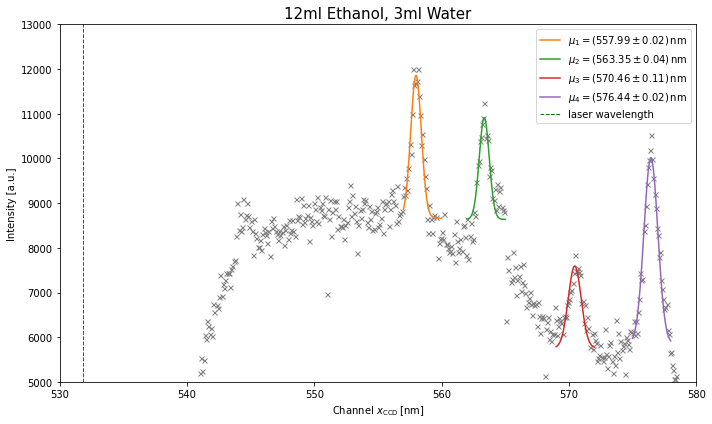

<ipython-input-7-4d9532f59611>:42: RuntimeWarning: invalid value encountered in sqrt
  u_params[i,:] = np.sqrt(covariance)


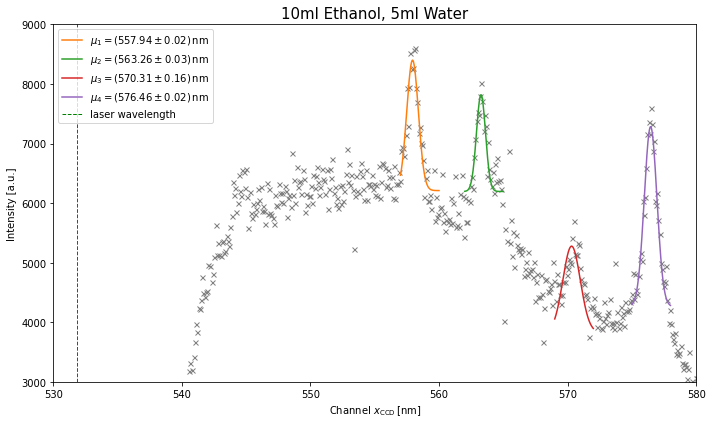

<ipython-input-7-4d9532f59611>:42: RuntimeWarning: invalid value encountered in sqrt
  u_params[i,:] = np.sqrt(covariance)


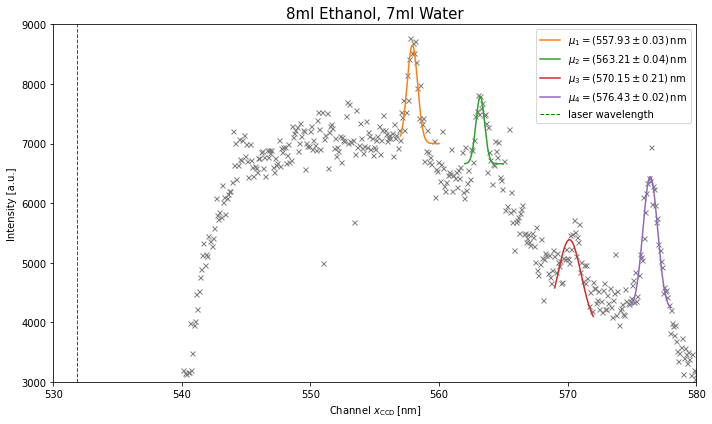

<ipython-input-7-4d9532f59611>:42: RuntimeWarning: invalid value encountered in sqrt
  u_params[i,:] = np.sqrt(covariance)


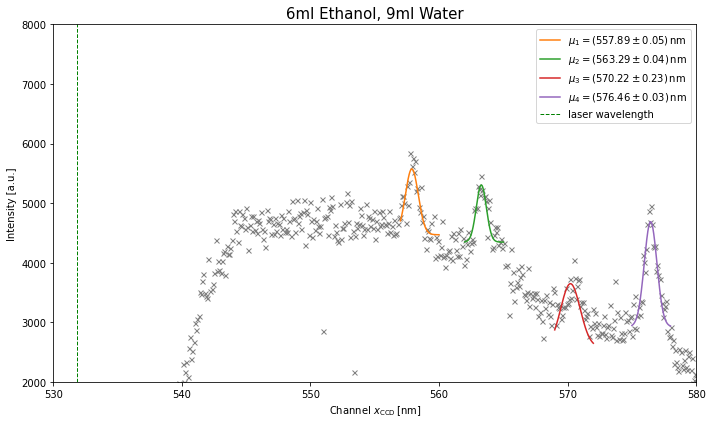

<ipython-input-7-4d9532f59611>:42: RuntimeWarning: invalid value encountered in sqrt
  u_params[i,:] = np.sqrt(covariance)


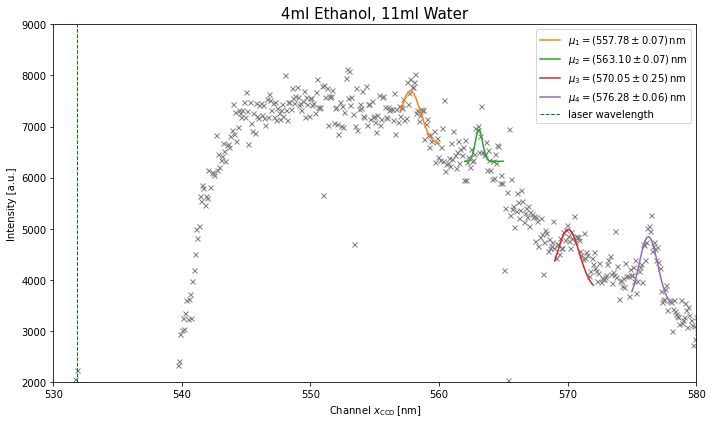

<ipython-input-7-4d9532f59611>:42: RuntimeWarning: invalid value encountered in sqrt
  u_params[i,:] = np.sqrt(covariance)


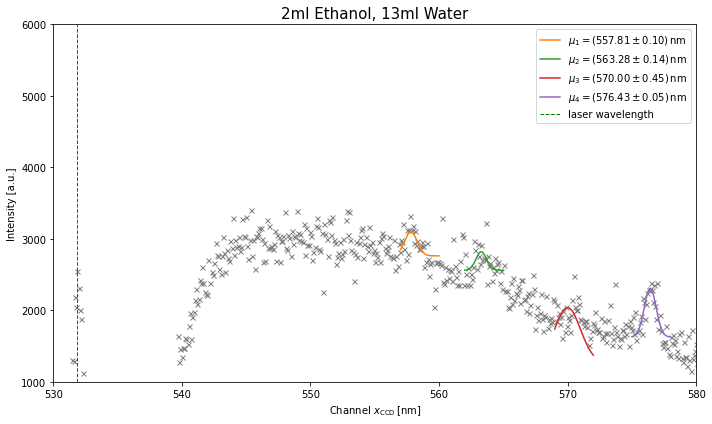

In [7]:
concentrations = [14, 12, 10, 8, 6, 4, 2]
Ns = [4,4,4,4,4,4,4]
n = len(concentrations)

a = [[1310, 1340], [1370, 1400], [1448, 1485], [1515, 1555]]
p1s = [[10, 5135, 10, 11, 5130,10, 0], [100, 5540, 10, 100, 5550, 10, 0]]
p0s = [[1e4, 557, 1, 1e3], [8e3, 564, 1, 1e3], [1e3, 570.3, 1, 0], [8e3, 577, 1, 0]]
xaxis = [np.linspace(557, 560, 1001), np.linspace(562, 565, 1001), np.linspace(569, 572, 1001),
         np.linspace(575, 578, 1001)]
xaxis1 = [np.linspace(5100, 5200, 1001), np.linspace(5400, 5500, 1001),
          np.linspace(5600, 5700, 1001), np.linspace(5700, 5900, 1001)]
ylimits = [[7000, 17000], [5000, 13000], [3000, 9000], [3000, 9000],
           [2000, 8000], [2000, 9000], [1000,6000]]
func1=gauss
func2=gauss

parameters = np.zeros((n, 4, 7))
u_params = np.zeros((n,4, 7,7))
for i in range(n):
    concentration = concentrations[i]
    if concentration == 14:
        a = [[1310, 1350], [1360, 1404], [1448, 1485], [1520, 1562]]
        p0s = [[1e4, 557, 1, 1e3], [8e3, 564, 1, 1e3], [1e3, 570.3, 1, 0], [8e3, 577, 1, 0]]
    else:
        a = [[1310, 1340], [1370, 1400], [1448, 1485], [1515, 1555]]
        p0s = [[1e4, 557, 1, 1e3], [8e3, 564, 1, 1e3], [1e3, 570.3, 1, 0], [8e3, 577, 1, 0]]
    if concentration == 2:
        a = [[1302, 1342], [1370, 1400], [1448, 1485], [1515, 1555]]
        p0s = [[1e3, 557, 1, .8e3], [8e3, 564, 1, 1e3], [1e3, 570.3, 1, 0], [8e3, 577, 1, 0]]

    file = 'CCD/ethanol_' + str(concentration) + 'ml.txt'
    df = pd.read_csv(file, skiprows=17, skipfooter=1, sep='\t',
                         names=['Channel', 'Counts'], decimal=',', engine = 'python')
    title = str(concentration)+'ml Ethanol, ' + str(15-concentration) + 'ml Water'
    N = Ns[i]

    y_counts = df['Counts']
    
    coefficients, covariance = fit_func(N=N, x=df['Channel'], y=y_counts, a=a,
                                        p0s=p0s,p1s=p1s, func1=func1, func2=func2,show=False)
    parameters[i,:] = coefficients
    u_params[i,:] = np.sqrt(covariance)
    draw_spectrum(num_fit=N, x=df['Channel'], y=y_counts, a=a, xaxis=xaxis,
                  xaxis1=xaxis1, coefficients=coefficients, covariance=covariance, title=title,
                  func1=func1, func2=func2,concentration=concentration,log=False,ylims=ylimits[i],
                  xlims=[530,580],avline=False)

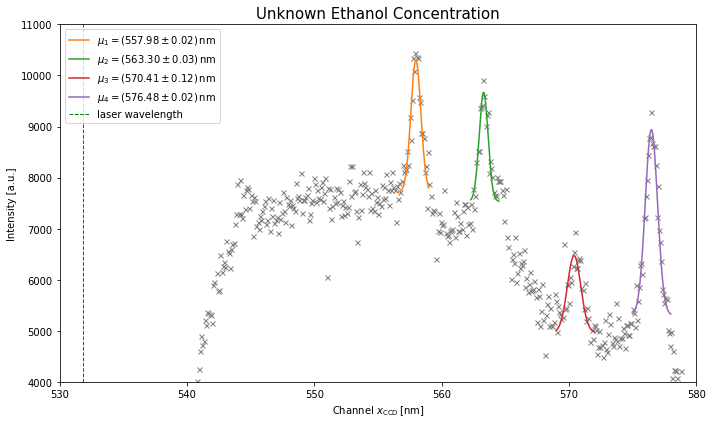

[2584.99003202 2137.38607825 1505.21295859 3634.35359739]


In [34]:
a = [[1310, 1342], [1370, 1403], [1440, 1490], [1517, 1543]]
p0s = [[1e4, 557, 1, 1e3], [8e3, 564, 1, 1e3], [1e3, 570.3, 1, 0], [8e3, 577, 1, 0]]
xaxis = [np.linspace(556.5, 559, 1001), np.linspace(562.3, 564.5, 1001), np.linspace(569, 572, 1001),
         np.linspace(575, 578, 1001)]
file = 'CCD/ethanol_unknown.txt'
df = pd.read_csv(file, skiprows=17, skipfooter=1, sep='\t',
                 names=['Channel', 'Counts'], decimal=',', engine = 'python')

title = 'Unknown Ethanol Concentration'
y_counts = df['Counts']
coefficients, covariance = fit_func(N=N, x=df['Channel'], y=y_counts, a=a,
                                    p0s=p0s,p1s=p1s, func1=func1, func2=func2,show=False)

draw_spectrum(num_fit=N, x=df['Channel'], y=y_counts, a=a, xaxis=xaxis,
                xaxis1=xaxis1, coefficients=coefficients, covariance=covariance, title=title,
                func1=func1, func2=func2,concentration=11,log=False,ylims=[4000,11000],
                xlims=[530,580],avline=False)
print(coefficients[:,0])

In [20]:
def ethanol(I, a, b, uI, ua, ub, uab):
    print('ua=',ua)
    print('ub=',ub)
    print('uI=',uI)
    E = (I-b)/a
    uE = np.sqrt((uI/a)**2 + (ub/a)**2 + ((I-b)/a**2 * ua)**2 + 2*(I-b)/a**3*uab)
    return E, uE

[ 255.10951305 -224.2948451 ] [12.7348893  82.95735115]
ua= 12.73488930361232
ub= 82.95735114575162
uI= 152.9491203689875
(11.012074161808899, 0.6885296353648609)
0
[ 176.90454915 -115.4262447 ] [ 16.06086638 105.47750102]
ua= 16.06086637790691
ub= 105.4775010239305
uI= 158.19312149190947
(12.734620640129384, 1.1339567846766405)
1
[103.97047526 570.73761327] [ 64.45529066 618.68553092]
ua= 64.45529065746165
ub= 618.6855309242561
uI= 335.3877269480654
(8.98789144667659, 3.938385350855519)
2
[323.34722804 -61.69916256] [10.73589778 82.11507118]
ua= 10.735897781116785
ub= 82.11507118492759
uI= 159.35036629928268
(11.430599799489046, 0.5344420332766506)
3


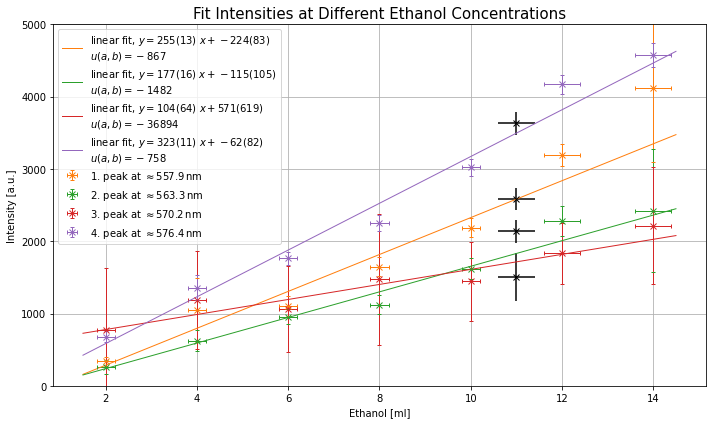

In [36]:
xconc = np.linspace(1.5, 14.5,1001)
concentration_errors = [0.4, 0.4, 0.2, 0.2, 0.2, 0.2, 0.2]
wavelength = np.zeros((n,4))
I = np.zeros((n, 4))
u_I = np.zeros((n, 4))
for i in range(n):
    I[i] = parameters[i,:,0]
    u_I[i] = u_params[i,:,0,0]
    wavelength[i] = parameters[i,:,1]

fig, ax = plt.subplots(figsize=(10,6))
for i in range(4):
    ax.errorbar(concentrations, I[:,i], yerr=u_I[:,i], capsize=2, elinewidth=1, xerr = concentration_errors,
                marker = 'x', lw=0, color = colors[i],
                label = r'{:.0f}. peak at $\approx {:.1f}\,$nm'.format(i+1, np.mean(wavelength[:,i])))
    ax.errorbar(11, coefficients[i,0], color = 'black', marker = 'x',
                xerr = 0.4, yerr = np.sqrt(covariance[i,0,0]))
    
    lin_params, lin_cov = sc.curve_fit(linear, concentrations, I[:,i], sigma=u_I[:,i], absolute_sigma=True)

    print(lin_params, np.sqrt(np.diagonal(lin_cov)))
    print(ethanol(coefficients[i,0], lin_params[0], lin_params[1],
                 np.sqrt(covariance[i,0,0]), np.sqrt(lin_cov[0,0]), np.sqrt(lin_cov[1,1]), lin_cov[0,1]))
    print(i)
    ax.plot(xconc, linear(xconc, *lin_params), color = colors[i], lw=1,
            label = r'linear fit, $y = {:.0f}({:.0f})~x + {:.0f}({:.0f})$'.format(
                lin_params[0], np.sqrt(lin_cov[0,0]), lin_params[1], np.sqrt(lin_cov[1,1]))
            + '\n' + r'$u(a, b) = {:.0f}$'.format(lin_cov[0,1]))

ax.set_ylim(0,5000)
ax.grid()
ax.legend()
ax.set_title(r'Fit Intensities at Different Ethanol Concentrations', size=15)
ax.set_xlabel(r'Ethanol [ml]')
ax.set_ylabel(r'Intensity [a.u.]')
plt.tight_layout()
# plt.savefig('Figures/Ethanol_linear_fit.pdf', dpi=800)
plt.show()